# 実践コンピュータビジョン
# 1章 基本的な画像処理

## 1.5 高度な例：画像のノイズ除去
テキストp.24  
Rudin-Osher-Fatemi (ROF) ノイズ除去モデルを用いて、画像のノイズ除去を行う。  
ROFモデルを用いると、エッジ（輪郭）や構造を維持しながら画像を滑らかにすることができる。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

ノイズ除去を行う関数denoiseを作成し、rof.pyに保存する。
```python
def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ A. Chambolle (2005)の数式(11)記載の計算手順に基づく
        Rudin-Osher-Fatemi (ROF) ノイズ除去モデルの実装。
        
        Input：
            im: ノイズのある入力像
            U_init: Uの初期ガウス分布
            tolerance: 終了判断基準の許容誤差
            tau: ステップ長
            tv_weight: TV正規化項の重み
        Output:
            U: ノイズ除去された画像
            im-U: 残余テクスチャ"""
        
    m,n = im.shape #size of noisy image

    # initialize
    U = U_init
    Px = np.zeros((m, n)) #x-component to the dual field
    Py = np.zeros((m, n)) #y-component of the dual field
    error = 1 
    
    while (error > tolerance):
        Uold = U
        
        # gradient of primal variable
        GradUx = np.roll(U,-1,axis=1)-U # x-component of U's gradient
        GradUy = np.roll(U,-1,axis=0)-U # y-component of U's gradient
        
        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx # non-normalized update of x-component (dual)
        PyNew = Py + (tau/tv_weight)*GradUy # non-normalized update of y-component (dual)
        NormNew = np.maximum(1,np.sqrt(PxNew**2+PyNew**2))
        
        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)
        
        # update the primal variable
        RxPx = np.roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = np.roll(Py,1,axis=0) # right y-translation of y-component
        
        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
        U = im + tv_weight*DivP # update of the primal variable
        
        # update of error
        error = np.linalg.norm(U-Uold)/np.sqrt(n*m);
        
    return U,im-U # denoised image and texture residual
```

In [2]:
import rof

In [3]:
from numpy import random
from scipy.ndimage import filters
from scipy.misc import imsave

### 正方形の合成画像のノイズ除去

In [4]:
# ノイズを含む画像を合成する
im = np.zeros((500,500))
im[100:400,100:400] = 128
im[200:300,200:300] = 255
im = im + 30*random.standard_normal((500,500))

U,T = rof.denoise(im,im)
G = filters.gaussian_filter(im,10)

In [5]:
# 結果を保存する
imsave('synth_original.pdf',im)
imsave('synth_rof.pdf',U)
imsave('synth_gaussian.pdf',G)

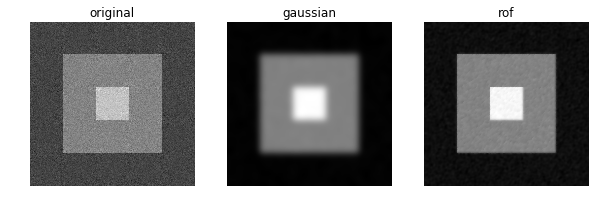

In [6]:
# 画像を表示する
imlist = [im, G, U]
tlist = ['original', 'gaussian', 'rof']
plt.figure(figsize=(10,10))
plt.gray()
for i, im, title in zip(range(3),imlist, tlist):
    plt.subplot(1,3,i+1)
    plt.imshow(im)
    plt.axis('off')
#     plt.axis('equal')
    plt.title(title)

### ビルの風景画像のノイズ除去
おなじみのエンパイアステートビルの画像を使ったノイズ除去

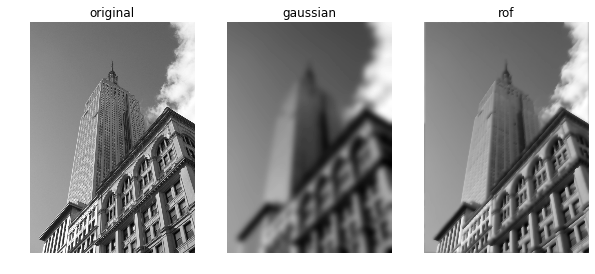

In [7]:
# オリジナル画像
im = np.array(Image.open('data/empire.jpg').convert('L'))
# gaussian fileter sigma = 10
G = filters.gaussian_filter(im, 10)
# ROFノイズ除去フィルタ
U, T = rof.denoise(im, im)

# 画像を表示する
imlist = [im, G, U]
tlist = ['original', 'gaussian', 'rof']
plt.figure(figsize=(10,10))
plt.gray()
for i, im, title in zip(range(3),imlist, tlist):
    plt.subplot(1,3,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title(title)